In [2]:
import pandas as pd
import numpy as np
import os
import time
import random
import gensim
import numpy as np
import os
import torch
from gensim.models import KeyedVectors
from matplotlib import pyplot as plt

In [3]:
pd.set_option("max_colwidth",1000000000)

In [4]:
data_folder = "/content/drive/My Drive/Colab Notebooks/Cyberbullying_WE_intrinsic_analysis/Data"
CB_data_folder = "/content/drive/My Drive/Colab Notebooks/Cyberbullying_WE_intrinsic_analysis/Data/CB_Data"

In [5]:
hurtlex_df = pd.read_csv(data_folder+"/Hurtlex.tsv", sep="\t")
hurtlex_df.category.unique()

array(['qas', 'cds', 'is', 're', 'om', 'an', 'or', 'svp', 'asm', 'pr',
       'dmc', 'asf', 'ddp', 'ps', 'pa', 'rci', 'ddf'], dtype=object)

In [6]:
len(hurtlex_df)

8228

In [7]:
len(hurtlex_df["lemma"].unique())

5963

In [8]:
len(hurtlex_df.drop_duplicates(subset=["lemma"]))

5963

In [9]:
duplicated_hurtlex = hurtlex_df[hurtlex_df.duplicated(subset=["lemma"])]

In [10]:
len(duplicated_hurtlex)

2265

In [11]:
duplicated_hurtlex.to_csv(data_folder+"/duplicated_hurtlex_vocab.csv")

In [12]:
hurtlex_df[hurtlex_df["lemma"].isin(duplicated_hurtlex["lemma"].values)]

id pos category stereotype           lemma         level
0     EN1382   n      qas         no        gag reel     inclusive
2     EN6856   n       is        yes       mendicant  conservative
3     EN5485   n       re         no         maffias  conservative
4     EN5024   n      cds         no  lying in trade  conservative
9      EN858   n       an         no          sucker     inclusive
...      ...  ..      ...        ...             ...           ...
8216  EN2043   n       re         no       fraudster     inclusive
8221   EN333   n       an         no       wish-wash  conservative
8224  EN1319   n      cds         no    mother fucka  conservative
8225  EN2597   n      cds         no          refuse  conservative
8226   EN521   n      asm         no          simple     inclusive

[3588 rows x 6 columns]

In [13]:
hurtlex_df = hurtlex_df.drop_duplicates(subset=["lemma"])

In [14]:
hurtlex_df_ps = hurtlex_df[(hurtlex_df["category"] == "ps")]["lemma"].unique() #& (hurtlex_df["stereotype"] == "yes")]
hurtlex_df_om = hurtlex_df[(hurtlex_df["category"] == "om")]["lemma"].unique() #& (hurtlex_df["stereotype"] == "no")]
hurtlex_df_qas = hurtlex_df[(hurtlex_df["category"] == "qas")]["lemma"].unique() #& (hurtlex_df["stereotype"] == "no")]
hurtlex_df_cds = hurtlex_df[(hurtlex_df["category"] == "cds")]["lemma"].unique() #& (hurtlex_df["stereotype"] == "no")]
hurtlex_df_is = hurtlex_df[(hurtlex_df["category"] == "is")]["lemma"].unique() #& (hurtlex_df["stereotype"] == "no")]
hurtlex_df_re = hurtlex_df[(hurtlex_df["category"] == "re")]["lemma"].unique() #& (hurtlex_df["stereotype"] == "no")]
hurtlex_df_pr = hurtlex_df[(hurtlex_df["category"] == "pr")]["lemma"].unique() #& (hurtlex_df["stereotype"] == "no")]
hurtlex_df_asf = hurtlex_df[(hurtlex_df["category"] == "asf")]["lemma"].unique() #& (hurtlex_df["stereotype"] == "no")]
hurtlex_df_asm = hurtlex_df[(hurtlex_df["category"] == "asm")]["lemma"].unique() #& (hurtlex_df["stereotype"] == "no")]
hurtlex_df_ddp = hurtlex_df[(hurtlex_df["category"] == "ddp")]["lemma"].unique() #& (hurtlex_df["stereotype"] == "yes")]
hurtlex_df_ddf = hurtlex_df[(hurtlex_df["category"] == "ddf")]["lemma"].unique() #& (hurtlex_df["stereotype"] == "yes")]

In [15]:
hurtlex_df_cds

array(['snotty', 'lying in trade', 'nerdiness', ..., 'faction',
       'fascisti', 'egoistic'], dtype=object)

In [16]:
def find_list_of_words_in_df(df, slur_list,cat):
  ps_in_hateEval = []
  for i in slur_list: 
    if  df['Text_clean'].str.contains(" "+i+" ").any() == True:
      ps = df[df["Text_clean"].str.contains(" "+i+" ")][["Text_clean","oh_label"]]
      ps["cat"] = cat
      #if ps.index not in ps_in_hateEval:
      ps_in_hateEval.append(ps)

  ps_in_hateEval_df = pd.concat(ps_in_hateEval).drop_duplicates(subset=["Text_clean"])
  return ps_in_hateEval_df

In [17]:
def return_dataset_with_hurtlex_unique(dataset_df):

  ps_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ps,"PS")
    
  om_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_om,"OM")

  qas_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_qas,"QAS")
  cds_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_cds,"CDS")
  is_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_is,"IS")
  re_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_re,"RE")
  pr_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_pr,"PR")
 
  asf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asf,"ASF")
  asm_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asm,"ASM")
  ddp_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddp,"DDP")
  ddf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddf,"DDF")


  test_set_cat = pd.concat([ps_in_ds,om_in_ds,qas_in_ds,cds_in_ds,is_in_ds,re_in_ds,pr_in_ds,
                           asf_in_ds, asm_in_ds,ddp_in_ds,ddf_in_ds ]).drop_duplicates(subset=["Text_clean"], keep=False)
 

  return test_set_cat                  


In [18]:
def return_hurtlex_in_dataset_unique(dataset_df):

  ps_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ps,"PS")
    
  om_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_om,"OM")

  qas_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_qas,"QAS")
  cds_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_cds,"CDS")
  is_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_is,"IS")
  re_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_re,"RE")
  pr_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_pr,"PR")
 
  asf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asf,"ASF")
  asm_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asm,"ASM")
  ddp_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddp,"DDP")
  ddf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddf,"DDF")


  test_set_cat = pd.concat([ps_in_ds,om_in_ds,qas_in_ds,cds_in_ds,is_in_ds,re_in_ds,pr_in_ds,
                           asf_in_ds, asm_in_ds,ddp_in_ds,ddf_in_ds ]).drop_duplicates(subset=["Text_clean"], keep=False)
 

  dataset_hurtlex_no = [len(test_set_cat[test_set_cat["cat"]=="PS"])/len(dataset_df),
                        len(test_set_cat[test_set_cat["cat"]=="OM"])/len(dataset_df),
                     len(test_set_cat[test_set_cat["cat"]=="QAS"])/len(dataset_df),
                     len(test_set_cat[test_set_cat["cat"]=="CDS"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="IS"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="RE"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="PR"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="ASF"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="ASM"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="DDP"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="DDF"])/len(dataset_df)]

  return dataset_hurtlex_no                  


In [19]:
def return_dataset_with_hurtlex(dataset_df):

  ps_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ps,"PS")
    
  om_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_om,"OM")

  qas_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_qas,"QAS")
  cds_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_cds,"CDS")
  is_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_is,"IS")
  re_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_re,"RE")
  pr_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_pr,"PR")
 
  asf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asf,"ASF")
  asm_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asm,"ASM")
  ddp_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddp,"DDP")
  ddf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddf,"DDF")


  test_set_cat = pd.concat([ps_in_ds,om_in_ds,qas_in_ds,cds_in_ds,is_in_ds,re_in_ds,pr_in_ds,
                           asf_in_ds, asm_in_ds,ddp_in_ds,ddf_in_ds ]).drop_duplicates(subset=["Text_clean"])
 

  return test_set_cat                  


In [20]:
def return_hurtlex_in_dataset(dataset_df):

  ps_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ps,"PS")
    
  om_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_om,"OM")

  qas_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_qas,"QAS")
  cds_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_cds,"CDS")
  is_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_is,"IS")
  re_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_re,"RE")
  pr_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_pr,"PR")
 
  asf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asf,"ASF")
  asm_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asm,"ASM")
  ddp_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddp,"DDP")
  ddf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddf,"DDF")


  test_set_cat = pd.concat([ps_in_ds,om_in_ds,qas_in_ds,cds_in_ds,is_in_ds,re_in_ds,pr_in_ds,
                           asf_in_ds, asm_in_ds,ddp_in_ds,ddf_in_ds ]).drop_duplicates(subset=["Text_clean"])
 

  dataset_hurtlex_no = [len(test_set_cat[test_set_cat["cat"]=="PS"])/len(dataset_df),
                        len(test_set_cat[test_set_cat["cat"]=="OM"])/len(dataset_df),
                     len(test_set_cat[test_set_cat["cat"]=="QAS"])/len(dataset_df),
                     len(test_set_cat[test_set_cat["cat"]=="CDS"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="IS"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="RE"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="PR"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="ASF"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="ASM"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="DDP"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="DDF"])/len(dataset_df)]

  return dataset_hurtlex_no                  


In [21]:
def return_hurtlex_cat_in_duplicated_data(dataset_df):

  ps_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ps,"PS")
    
  om_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_om,"OM")

  qas_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_qas,"QAS")
  cds_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_cds,"CDS")
  is_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_is,"IS")
  re_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_re,"RE")
  pr_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_pr,"PR")
 
  asf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asf,"ASF")
  asm_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asm,"ASM")
  ddp_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddp,"DDP")
  ddf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddf,"DDF")


  test_set_cat = pd.concat([ps_in_ds,om_in_ds,qas_in_ds,cds_in_ds,is_in_ds,re_in_ds,pr_in_ds,
                           asf_in_ds, asm_in_ds,ddp_in_ds,ddf_in_ds ])
 

  dataset_hurtlex_no = [len(test_set_cat[test_set_cat["cat"]=="PS"])/len(dataset_df),
                        len(test_set_cat[test_set_cat["cat"]=="OM"])/len(dataset_df),
                     len(test_set_cat[test_set_cat["cat"]=="QAS"])/len(dataset_df),
                     len(test_set_cat[test_set_cat["cat"]=="CDS"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="IS"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="RE"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="PR"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="ASF"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="ASM"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="DDP"])/len(dataset_df),
                    len(test_set_cat[test_set_cat["cat"]=="DDF"])/len(dataset_df)]

  return dataset_hurtlex_no                  


In [22]:
def return_dataset_duplicated_hurtlex_in_dataset(dataset_df):

  ps_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ps,"PS")
    
  om_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_om,"OM")

  qas_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_qas,"QAS")
  cds_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_cds,"CDS")
  is_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_is,"IS")
  re_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_re,"RE")
  pr_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_pr,"PR")
 
  asf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asf,"ASF")
  asm_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asm,"ASM")
  ddp_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddp,"DDP")
  ddf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddf,"DDF")


  test_set_cat = pd.concat([ps_in_ds,om_in_ds,qas_in_ds,cds_in_ds,is_in_ds,re_in_ds,pr_in_ds,
                           asf_in_ds, asm_in_ds,ddp_in_ds,ddf_in_ds ])
 

  return test_set_cat


In [23]:
def return_duplicated_hurtlex_in_dataset(dataset_df):

  ps_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ps,"PS")
    
  om_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_om,"OM")

  qas_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_qas,"QAS")
  cds_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_cds,"CDS")
  is_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_is,"IS")
  re_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_re,"RE")
  pr_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_pr,"PR")
 
  asf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asf,"ASF")
  asm_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_asm,"ASM")
  ddp_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddp,"DDP")
  ddf_in_ds = find_list_of_words_in_df(dataset_df, hurtlex_df_ddf,"DDF")


  test_set_cat = pd.concat([ps_in_ds,om_in_ds,qas_in_ds,cds_in_ds,is_in_ds,re_in_ds,pr_in_ds,
                           asf_in_ds, asm_in_ds,ddp_in_ds,ddf_in_ds ])
 
  duplicated_test_Set = test_set_cat[test_set_cat.duplicated(subset=["Text_clean"], keep=False)]["Text_clean"].unique()

  dataset_hurtlex_no = len(duplicated_test_Set)/len(dataset_df)

  return dataset_hurtlex_no


# HateEval DS

In [24]:
hateEval_train_df = pd.read_csv(CB_data_folder+"/HateEval/HateEval_data_train.csv", index_col=False)
hateEval_test_df = pd.read_csv(CB_data_folder+"/HateEval/HateEval_data_test.csv", index_col=False)

hateEval_df = pd.concat([hateEval_train_df,hateEval_test_df])
hateEval_df = hateEval_df.dropna()

In [25]:
len(hateEval_df)

12722

In [26]:
hateEval_hurtlex_no = return_hurtlex_in_dataset_unique(hateEval_df)
hateEval_duplicated_hurtlex_no = return_duplicated_hurtlex_in_dataset(hateEval_df)
hateEval_with_duplicated_hurtlex = return_dataset_duplicated_hurtlex_in_dataset(hateEval_df)
hateEval_duplictates_Hurtlext_no = return_hurtlex_cat_in_duplicated_data(hateEval_with_duplicated_hurtlex)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
hateEval_with_hurtlex = return_dataset_with_hurtlex_unique(hateEval_df)
hateEval_without_hurtlex = hateEval_df[(~hateEval_df["Text_clean"].isin(hateEval_with_hurtlex.Text_clean.values)) &
                                       (~hateEval_df["Text_clean"].isin(hateEval_with_duplicated_hurtlex.Text_clean.values))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [28]:
np.sum(hateEval_hurtlex_no)+np.sum(hateEval_duplicated_hurtlex_no)+len(hateEval_without_hurtlex)/len(hateEval_df)

1.0

In [29]:
np.sum(hateEval_hurtlex_no)+ + len(hateEval_without_hurtlex)/len(hateEval_df)

0.7665461405439397

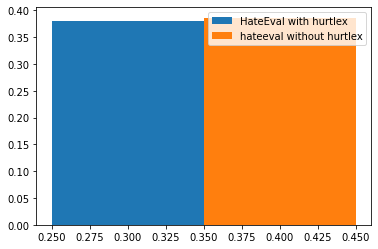

In [30]:
data = [len(hateEval_with_hurtlex)/len(hateEval_df), len(hateEval_without_hurtlex)/len(hateEval_df)]
ind = 0.3
plt.bar(ind + 0 ,len(hateEval_with_hurtlex)/len(hateEval_df), label="HateEval with hurtlex", width=0.1)
plt.bar(ind + 0.1,len(hateEval_without_hurtlex)/len(hateEval_df), label="hateeval without hurtlex", width=0.1)
plt.legend()

# Kaggle DS

In [31]:
Kaggle_train_df = pd.read_csv(CB_data_folder+"/Kaggle/kaggle_data_train.csv", index_col=False)
Kaggle_test_df = pd.read_csv(CB_data_folder+"/Kaggle/kaggle_data_test.csv", index_col=False)

kaggle_df = pd.concat([Kaggle_train_df,Kaggle_test_df])
kaggle_df = kaggle_df.dropna()

kaggle_hurtlex_no = return_hurtlex_in_dataset_unique(kaggle_df)
kaggle_duplicated_hurtlex_no = return_duplicated_hurtlex_in_dataset(kaggle_df)
kaggle_with_duplicated_hurtlex = return_dataset_duplicated_hurtlex_in_dataset(kaggle_df)
kaggle_duplictates_Hurtlext_no = return_hurtlex_cat_in_duplicated_data(kaggle_with_duplicated_hurtlex)
kaggle_with_hurtlex = return_dataset_with_hurtlex_unique(kaggle_df)
kaggle_without_hurtlex = kaggle_df[(~kaggle_df["Text_clean"].isin(kaggle_with_duplicated_hurtlex.Text_clean.values)) &
                                   (~kaggle_df["Text_clean"].isin(kaggle_with_hurtlex.Text_clean.values))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
np.sum(kaggle_hurtlex_no)+np.sum(kaggle_duplicated_hurtlex_no)+len(kaggle_without_hurtlex)/len(kaggle_df)

1.0

# Twitter-sexism

In [33]:
twitter_sex_train_df = pd.read_csv(CB_data_folder+"/Twitter_sexism/Twitter_sex_data_train.csv", index_col=False)
twitter_sex_test_df = pd.read_csv(CB_data_folder+"/Twitter_sexism/Twitter_sex_data_test.csv", index_col=False)

twitter_sex_df = pd.concat([twitter_sex_train_df,twitter_sex_test_df])
twitter_sex_df = twitter_sex_df.dropna()

twitter_sex_hurtlex_no = return_hurtlex_in_dataset_unique(twitter_sex_df)
twitter_sex_duplicated_hurtlex_no = return_duplicated_hurtlex_in_dataset(twitter_sex_df)
twitter_sex_with_duplicated_hurtlex = return_dataset_duplicated_hurtlex_in_dataset(twitter_sex_df)
twitter_sex_duplictates_Hurtlext_no = return_hurtlex_cat_in_duplicated_data(twitter_sex_with_duplicated_hurtlex)
twitter_sex_with_hurtlex = return_dataset_with_hurtlex_unique(twitter_sex_df)
twitter_sex_without_hurtlex = twitter_sex_df[ (~twitter_sex_df["Text_clean"].isin(twitter_sex_with_duplicated_hurtlex.Text_clean.values)) &
                                             (~twitter_sex_df["Text_clean"].isin(twitter_sex_with_hurtlex.Text_clean.values))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [34]:
np.sum(twitter_sex_hurtlex_no)+ np.sum(twitter_sex_duplicated_hurtlex_no)+len(twitter_sex_without_hurtlex)/len(twitter_sex_df)

1.0

# Twitter_racism

In [35]:
twitter_rac_train_df = pd.read_csv(CB_data_folder+"/Twitter_racism/Twitter_rac_data_train.csv", index_col=False)
twitter_rac_test_df = pd.read_csv(CB_data_folder+"/Twitter_racism/Twitter_rac_data_test.csv", index_col=False)

twitter_rac_df = pd.concat([twitter_rac_train_df,twitter_rac_test_df])
twitter_rac_df = twitter_rac_df.dropna()

twitter_rac_hurtlex_no = return_hurtlex_in_dataset_unique(twitter_rac_df)
twitter_rac_duplicated_hurtlex_no = return_duplicated_hurtlex_in_dataset(twitter_rac_df)
twitter_rac_with_duplicated_hurtlex = return_dataset_duplicated_hurtlex_in_dataset(twitter_rac_df)
twitter_rac_duplictates_Hurtlext_no = return_hurtlex_cat_in_duplicated_data(twitter_rac_with_duplicated_hurtlex)
twitter_rac_with_hurtlex = return_dataset_with_hurtlex_unique(twitter_rac_df)
twitter_rac_without_hurtlex = twitter_rac_df[(~twitter_rac_df["Text_clean"].isin(twitter_rac_with_duplicated_hurtlex.Text_clean.values)) &
                                             (~twitter_rac_df["Text_clean"].isin(twitter_rac_with_hurtlex.Text_clean.values))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
np.sum(twitter_rac_hurtlex_no)+ np.sum(twitter_rac_duplicated_hurtlex_no)+len(twitter_rac_without_hurtlex)/len(twitter_rac_df)

1.0

# jigsaw_tox

In [ ]:
jig_tox_train_df = pd.read_csv(CB_data_folder+"/Jigsaw_tox/jigsaw_data_sample_100k_train.csv", index_col=False)
jig_tox_test_df = pd.read_csv(CB_data_folder+"/Jigsaw_tox/jigsaw_data_sample_100k_test.csv", index_col=False)

jig_tox_df = pd.concat([jig_tox_train_df,jig_tox_test_df])
jig_tox_df = jig_tox_df.dropna()

jig_tox_df = jig_tox_df.rename(columns={"toxic":"oh_label"})

jig_tox_hurtlex_no = return_hurtlex_in_dataset_unique(jig_tox_df)
jig_tox_duplicated_hurtlex_no = return_duplicated_hurtlex_in_dataset(jig_tox_df)
jig_tox_with_duplicated_hurtlex = return_dataset_duplicated_hurtlex_in_dataset(jig_tox_df)
jig_tox_duplictates_Hurtlext_no = return_hurtlex_cat_in_duplicated_data(jig_tox_with_duplicated_hurtlex)
jig_tox_with_hurtlex = return_dataset_with_hurtlex_unique(jig_tox_df)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
jig_tox_without_hurtlex = jig_tox_df[ (~jig_tox_df["Text_clean"].isin(jig_tox_with_duplicated_hurtlex.Text_clean.values)) &
                                     (~jig_tox_df["Text_clean"].isin(jig_tox_with_hurtlex.Text_clean.values))]

In [ ]:
np.sum(jig_tox_hurtlex_no)+np.sum(jig_tox_duplicated_hurtlex_no)+len(jig_tox_without_hurtlex)/len(jig_tox_df)

1.0

# plotting the dataset

In [ ]:
dic = {"Dataset":["hateEval","Kaggle", "twitter-sex","twitter-rac","jigsaw"],
       "PS":[hateEval_hurtlex_no[0]*100,kaggle_hurtlex_no[0]*100,twitter_sex_hurtlex_no[0]*100,twitter_rac_hurtlex_no[0]*100,jig_tox_hurtlex_no[0]*100],
       "OM":[hateEval_hurtlex_no[1]*100,kaggle_hurtlex_no[1]*100,twitter_sex_hurtlex_no[1]*100,twitter_rac_hurtlex_no[1]*100,jig_tox_hurtlex_no[1]*100],
       "QAS":[hateEval_hurtlex_no[2]*100,kaggle_hurtlex_no[2]*100,twitter_sex_hurtlex_no[2]*100,twitter_rac_hurtlex_no[2]*100,jig_tox_hurtlex_no[2]*100],
       "CDS":[hateEval_hurtlex_no[3]*100,kaggle_hurtlex_no[3]*100,twitter_sex_hurtlex_no[3]*100,twitter_rac_hurtlex_no[3]*100,jig_tox_hurtlex_no[3]*100],
       "IS":[hateEval_hurtlex_no[4]*100,kaggle_hurtlex_no[4]*100,twitter_sex_hurtlex_no[4]*100,twitter_rac_hurtlex_no[4]*100,jig_tox_hurtlex_no[4]*100],
       "RE":[hateEval_hurtlex_no[5]*100,kaggle_hurtlex_no[5]*100,twitter_sex_hurtlex_no[5]*100,twitter_rac_hurtlex_no[5]*100,jig_tox_hurtlex_no[5]*100],
       "PR":[hateEval_hurtlex_no[6]*100,kaggle_hurtlex_no[6]*100,twitter_sex_hurtlex_no[6]*100,twitter_rac_hurtlex_no[6]*100,jig_tox_hurtlex_no[6]*100],
       "ASF":[hateEval_hurtlex_no[7]*100,kaggle_hurtlex_no[7]*100,twitter_sex_hurtlex_no[7]*100,twitter_rac_hurtlex_no[7]*100,jig_tox_hurtlex_no[7]*100],
       "ASM":[hateEval_hurtlex_no[8]*100,kaggle_hurtlex_no[8]*100,twitter_sex_hurtlex_no[8]*100,twitter_rac_hurtlex_no[8]*100,jig_tox_hurtlex_no[8]*100],
       "DDP":[hateEval_hurtlex_no[9]*100,kaggle_hurtlex_no[9]*100,twitter_sex_hurtlex_no[9]*100,twitter_rac_hurtlex_no[9]*100,jig_tox_hurtlex_no[0]*100],
       "DDF":[hateEval_hurtlex_no[10]*100,kaggle_hurtlex_no[10]*100,twitter_sex_hurtlex_no[10]*100,twitter_rac_hurtlex_no[10]*100,jig_tox_hurtlex_no[10]*100],
       "Mixed":[hateEval_duplicated_hurtlex_no *100, kaggle_duplicated_hurtlex_no*100, twitter_sex_duplicated_hurtlex_no*100,twitter_rac_duplicated_hurtlex_no*100, jig_tox_duplicated_hurtlex_no*100],
       "No_hurtlex":[len(hateEval_without_hurtlex)/len(hateEval_df)*100, len(kaggle_without_hurtlex)/len(kaggle_df)*100, len(twitter_sex_without_hurtlex)/len(twitter_sex_df)*100,
               len(twitter_rac_without_hurtlex)/len(twitter_rac_df)*100, len(jig_tox_without_hurtlex)/len(jig_tox_df)*100]}

In [ ]:
df = pd.DataFrame.from_dict(dic)

In [ ]:
df.sum(axis=1)

0    100.000000
1    100.000000
2    100.000000
3    100.000000
4     99.483647
dtype: float64

In [ ]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [ ]:
color=['#808080', '#000000', '#FF0000', '#800000',
            '#808000', '#00FFFF', '#0000FF', '#FF00FF', '#008000',
            '#FFFF00', '#000080', "#9370DB", '#FF7F50']

In [ ]:
df[["No_hurtlex"]]

No_hurtlex
0   38.626002
1   44.923630
2   65.988241
3   63.620474
4   41.480679

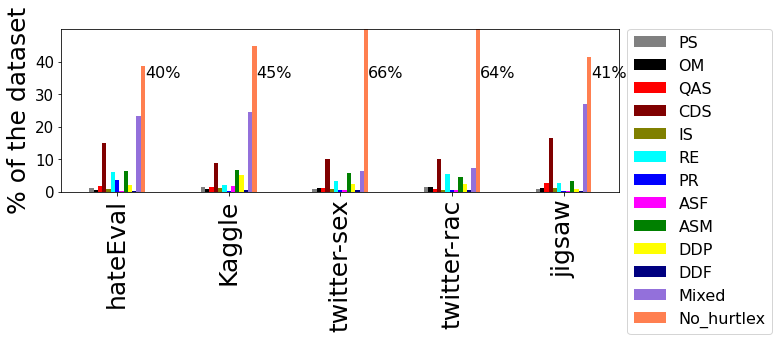

In [ ]:
ax = df.plot(kind="bar",figsize = (10, 3),color=color)
plt.ylim(0,50)
ax.annotate('40%', xy=(0.25, 35), xytext=(0.25, 35), fontsize=12)
ax.annotate('45%', xy=(1.25, 35), xytext=(1.25, 35), fontsize=12)
ax.annotate('66%', xy=(2.25, 35), xytext=(2.25, 35), fontsize=12)
ax.annotate('64%', xy=(3.25, 35), xytext=(3.25, 35), fontsize=12)
ax.annotate('41%', xy=(4.25, 35), xytext=(4.25, 35), fontsize=12)
plt.xticks(np.arange(0,5,1), labels=df.Dataset.unique(), fontsize=12, fontweight="bold")
plt.yticks(np.arange(0,50,10),fontsize=12, fontweight="bold")
plt.legend(bbox_to_anchor=(1.12, 1))
plt.ylabel("% of the dataset", fontsize=12, fontweight="bold")
#plt.xlabel("datasets", fontsize=25)
plt.legend(bbox_to_anchor=(1, 1.05), fontsize=12, ncol=11)

In [ ]:
 images_folder = "/content/drive/My Drive/Colab Notebooks/Cyberbullying_WE_intrinsic_analysis/images"

In [ ]:
fig = ax.get_figure()
fig.savefig(images_folder+"/prcntg_of_all_lexicon_for_each_ds_zoom.eps", format='eps',bbox_inches='tight') 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
